## Creating the model

**Description**  
This is the notebook where the model was trained, and then exported as ```.tflite``` format so that it could be embeeded into the android app.  
  
**Why MobileNetV2?**  
MobileNetV2 is the lastest release from Google as the best neural network model for image classification designed specifically to run on mobile phones. As this is a image classification problem (into 5 categories), and it is going to be implemented on a mobile app, this is the perfect model to solve the problem.  
  
**How many images where user to train and test the model?**  
Train dataset (80%): 1864  
Test dataset (20%):  466  
Total dataset: 2,330 images  

**Why was IMG_SIZE choosen to be 224x224 pixels?**  
That is MobileNetV2 default image size, apart from the fact it is not too big so that my local computer can't run it but neither is it too small so that the resulting model is not good enough.


**Import libraries**

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

from tensorflow.keras import layers, Input, Model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import random

**Set global variables: LABELS and IMG_SIZE (the size of the image our model will input)**

In [5]:
LABELS = [
    "italian",
    "japanese",
    "drinks",
    "coffee",
    "burgers"
]

IMG_SIZE = 224

In [3]:
def get_data(data_dir):
    """
    Returns all data with their class number as a Numpy array
    """
    
    global LABELS, IMG_SIZE
    
    data = [] 
    for label in LABELS: 
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            try:
                # Convert BGR to RGB format
                image_array = cv2.imread(os.path.join(path, img))[...,::-1]
                
                # Reshaping images to preferred size
                resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)

    data_array = np.array(data)
    np.random.shuffle(data_array)
    size = len(data_array)
    print(f"IMAGES FOR TRAINING", int(size*0.8))
    print(f"IMAGES FOR TESTING", int(size - size*0.8))
    return data_array[:int(size*0.8)], data_array[int(size*0.8):]

In [6]:
train_data, test_data = get_data("/Users/pabloblanco/Desktop/Places/ml/datasets")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


IMAGES FOR TRAINING 1864
IMAGES FOR TESTING 466


/var/folders/t8/ymw___8n3mb1w_c241wwfbym0000gn/T/ipykernel_96534/4194544119.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_array = np.array(data)


### Count of images per dataset per class

/Users/pabloblanco/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Train dataset')

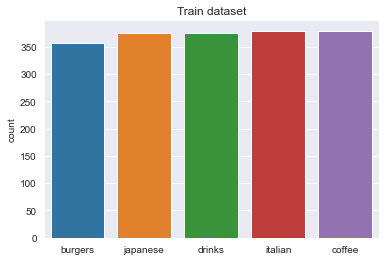

In [7]:
classes = []

for point in train_data:
    if(point[1] == 0):
        classes.append("italian")
    elif(point[1] == 1):
        classes.append("japanese")
    elif(point[1] == 2):
        classes.append("drinks")
    elif(point[1] == 3):
        classes.append("coffee")
    elif(point[1] == 4):
        classes.append("burgers")
        
sns.set_style('darkgrid')
sns.countplot(classes).set_title("Train dataset")

/Users/pabloblanco/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test dataset')

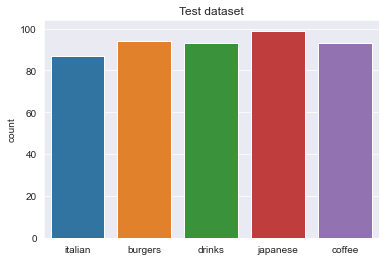

In [8]:
classes = []

for point in test_data:
    if(point[1] == 0):
        classes.append("italian")
    elif(point[1] == 1):
        classes.append("japanese")
    elif(point[1] == 2):
        classes.append("drinks")
    elif(point[1] == 3):
        classes.append("coffee")
    elif(point[1] == 4):
        classes.append("burgers")
        
sns.set_style('darkgrid')
sns.countplot(classes).set_title("Test dataset")

### Sneak peek at images inside training dataset

/var/folders/t8/ymw___8n3mb1w_c241wwfbym0000gn/T/ipykernel_96534/1651993604.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (5,5))


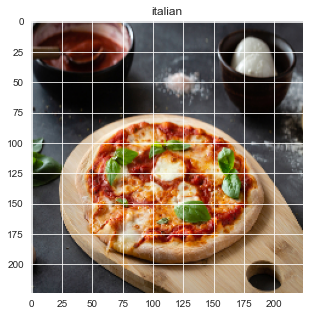

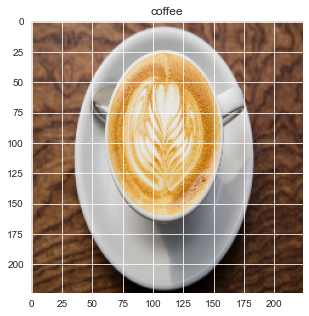

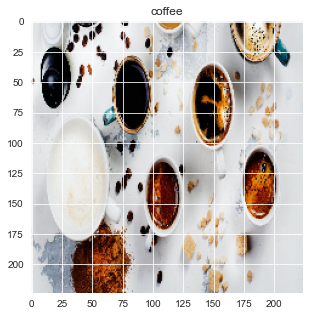

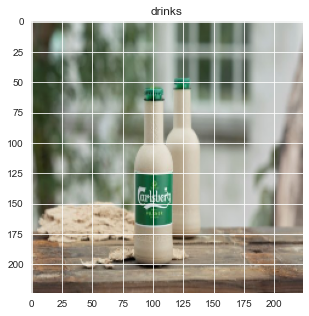

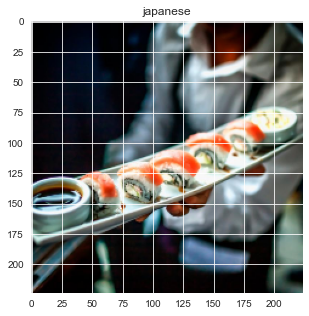

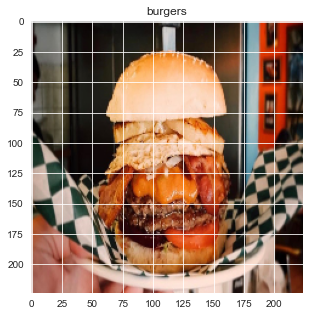

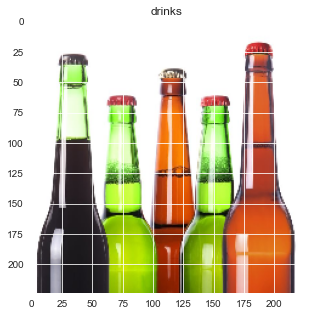

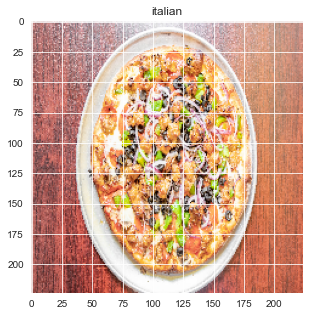

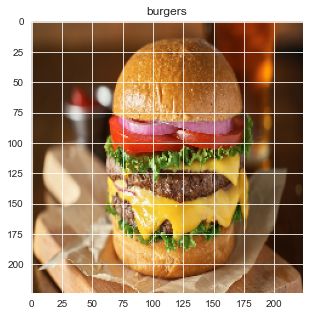

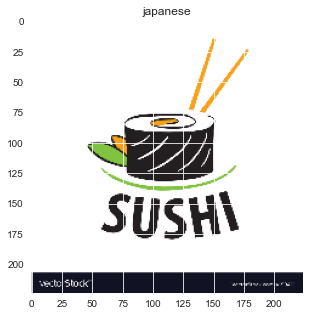

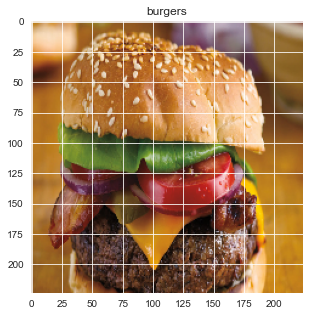

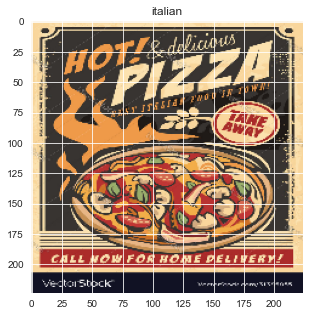

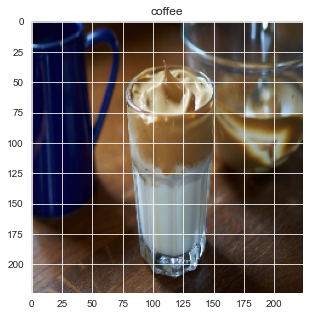

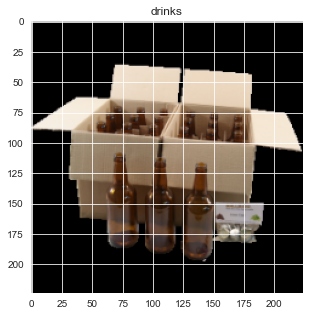

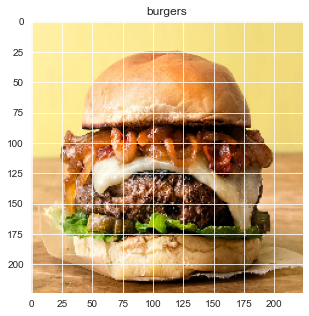

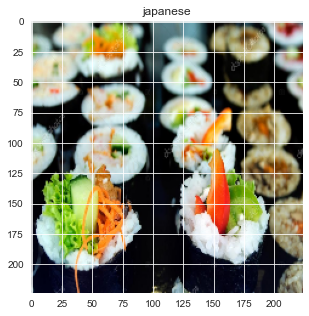

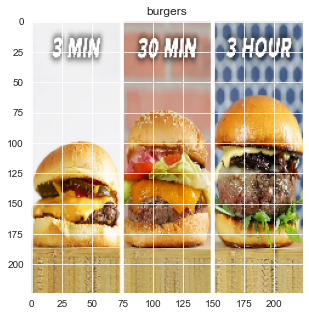

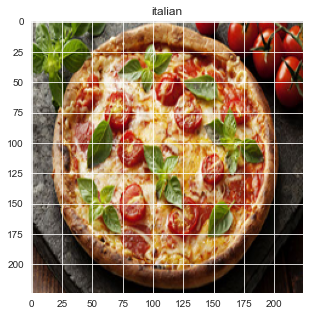

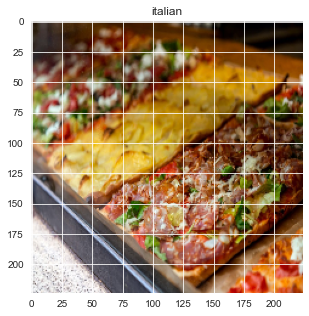

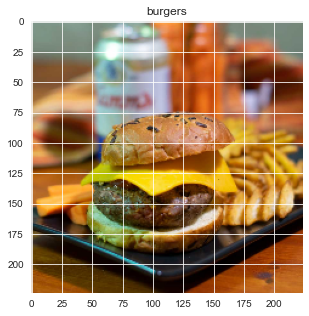

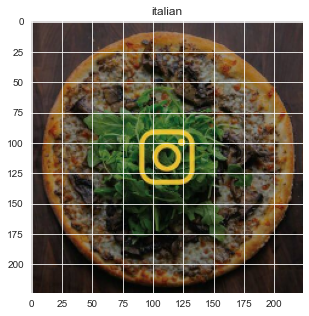

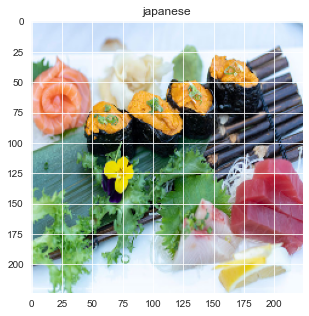

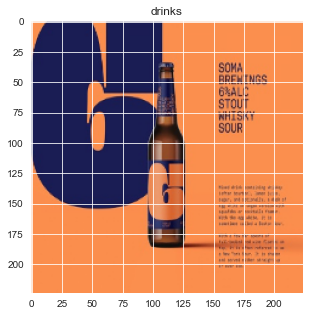

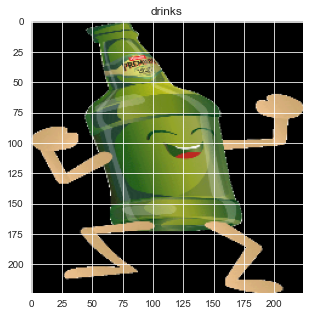

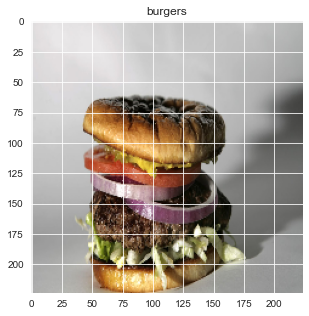

In [11]:
# Generate 25 unique random numbers within the train dataset
images = random.sample(range(0, len(train_data)), 25)

for image in images:
    plt.figure(figsize = (5,5))
    plt.imshow(train_data[image][0])
    plt.title(LABELS[train_data[image][1]])

### Preprocess in order to start training the model

In [12]:
x_train = []
y_train = []
x_val = []
y_val = []

# Get values and divide labels and images
for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_data:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

# Reshape images to required image size, and labels to correspond to size of images numpy array
x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.asarray(y_val).reshape(-1, 1)

### Import base MobileNetV2 model from TensorFlow

**Description:**  
The model is imported with the input_shape that we have in our dataset images. Also, the top layer is not included to in order to add our own layer which classifies between our own classes. The weights are set to be the ones from the ImageNet image database.

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

2021-07-16 22:23:33.245962: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**The base model is set to NOT trainable to not disrupt the weights imported. Only the last layer will be trainable**

In [14]:
base_model.trainable = False

**Our final model is constructed using the base model + our own top layer**

A GlobalAveragePooling is used instead a Fully Connected Layer as it prevents from over-fitting joined with the dropout.

In [15]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(5, activation="softmax")                                     
                                ])

**The model is compiled and starts to train**

In [16]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# Set so that each iteration is saved on disk in case something happens overnight or want to retrieve a certain epoch
callbacks = [
    ModelCheckpoint("save_at_{epoch}_02.h5")
]

history = model.fit(x_train, y_train, epochs=150, validation_data=(x_val, y_val), callbacks=callbacks, verbose=1)

/Users/pabloblanco/miniconda3/envs/ml/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-07-16 22:24:16.273144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
59/59 [==============================] - 25s 400ms/step - loss: 2.1692 - accuracy: 0.1840 - val_loss: 2.0267 - val_accuracy: 0.1652
Epoch 2/150


/Users/pabloblanco/miniconda3/envs/ml/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


59/59 [==============================] - 23s 388ms/step - loss: 2.0690 - accuracy: 0.1947 - val_loss: 1.9360 - val_accuracy: 0.1781
Epoch 3/150
59/59 [==============================] - 23s 390ms/step - loss: 1.9682 - accuracy: 0.2039 - val_loss: 1.8540 - val_accuracy: 0.1931
Epoch 4/150
59/59 [==============================] - 23s 387ms/step - loss: 1.9102 - accuracy: 0.2157 - val_loss: 1.7813 - val_accuracy: 0.2232
Epoch 5/150
59/59 [==============================] - 23s 388ms/step - loss: 1.8270 - accuracy: 0.2275 - val_loss: 1.7154 - val_accuracy: 0.2489
Epoch 6/150
59/59 [==============================] - 23s 396ms/step - loss: 1.7485 - accuracy: 0.2532 - val_loss: 1.6538 - val_accuracy: 0.2811
Epoch 7/150
59/59 [==============================] - 23s 392ms/step - loss: 1.6977 - accuracy: 0.2591 - val_loss: 1.5964 - val_accuracy: 0.3305
Epoch 8/150
59/59 [==============================] - 23s 394ms/step - loss: 1.6273 - accuracy: 0.3112 - val_loss: 1.5418 - val_accuracy: 0.3670
Epoc

59/59 [==============================] - 24s 402ms/step - loss: 0.2848 - accuracy: 0.9093 - val_loss: 0.3196 - val_accuracy: 0.9013
Epoch 115/150
59/59 [==============================] - 23s 396ms/step - loss: 0.2803 - accuracy: 0.9147 - val_loss: 0.3189 - val_accuracy: 0.9013
Epoch 116/150
59/59 [==============================] - 24s 404ms/step - loss: 0.2796 - accuracy: 0.9142 - val_loss: 0.3177 - val_accuracy: 0.9013
Epoch 117/150
59/59 [==============================] - 24s 400ms/step - loss: 0.2760 - accuracy: 0.9168 - val_loss: 0.3164 - val_accuracy: 0.9013
Epoch 118/150
59/59 [==============================] - 24s 411ms/step - loss: 0.2824 - accuracy: 0.9131 - val_loss: 0.3153 - val_accuracy: 0.9034
Epoch 119/150
59/59 [==============================] - 24s 406ms/step - loss: 0.2707 - accuracy: 0.9211 - val_loss: 0.3133 - val_accuracy: 0.9034
Epoch 120/150
59/59 [==============================] - 23s 399ms/step - loss: 0.2760 - accuracy: 0.9104 - val_loss: 0.3119 - val_accuracy:

### Create classification report

In [18]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names=LABELS))

/Users/pabloblanco/miniconda3/envs/ml/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

     italian       0.83      0.93      0.88        85
    japanese       0.89      0.78      0.83        90
      drinks       0.93      0.92      0.93        89
      coffee       0.90      0.93      0.92       100
     burgers       0.96      0.95      0.96       102

    accuracy                           0.90       466
   macro avg       0.90      0.90      0.90       466
weighted avg       0.90      0.90      0.90       466



## Save model and export it as .tflite

In [19]:
from tensorflow.saved_model import save

In [20]:
tf.keras.models.save_model(model, "/Users/pabloblanco/Desktop/Places/ml/saved_model")

2021-07-16 23:26:48.072784: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/Users/pabloblanco/miniconda3/envs/ml/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /Users/pabloblanco/Desktop/Places/ml/saved_model_burgers/assets


INFO:tensorflow:Assets written to: /Users/pabloblanco/Desktop/Places/ml/saved_model_burgers/assets


**Convert to ```.tflite```**

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model("/Users/pabloblanco/Desktop/Places/ml/saved_model")
converter.post_training_quantize=True
tflite_model = converter.convert()

2021-07-16 23:27:10.671442: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-07-16 23:27:10.671456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-07-16 23:27:10.671460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.
2021-07-16 23:27:10.672339: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /Users/pabloblanco/Desktop/Places/ml/saved_model_burgers
2021-07-16 23:27:10.712890: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-07-16 23:27:10.712914: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /Users/pabloblanco/Desktop/Places/ml/saved_model_burgers
2021-07-16 23:27:10.892250: I tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-07-16 23:27:11.303410: I tensorflow/cc/saved_model/loader.cc:1

**Write ```.tflite``` model in disk**

In [22]:
# Create the tflite model file
tflite_model_name = "model.tflite"
open(tflite_model_name, "wb").write(tflite_model)

8895836